<a href="https://colab.research.google.com/github/stavIatrop/Fake-News-Detection/blob/master/Pytorch/lstm_neural_network_politifact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import and split the data

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

data = pd.read_csv("drive/My Drive/datasets/politifact.csv", ",")                           #load politifact data 
data_labels = data['label'].values
data = data['text'].values

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(data, data_labels):
    X_train, X_test = data[train_index], data[test_index]
    Y_train, Y_test = data_labels[train_index], data_labels[test_index]

print("Train shape : ",X_train.shape)
print("Test shape : ",X_test.shape)

Train shape :  (559,)
Test shape :  (140,)


Preprocess the data.

In [2]:
import re

def remove_non_ascii(X):
  for i in range(len(X)):
    words = X[i].split()
    filtered_list = []
    for word in words:
        pattern = re.compile('[^\u0000-\u007F]+', re.UNICODE)  #Remove all non-alphanumeric characters
        
        word = pattern.sub(" ", word)
        filtered_list.append(word)
        result = ' '.join(filtered_list)
        
    X[i] = result
  return X

def toLowerCase(X):

  for i in range(len(X)):
    filtered_list = []
    for word in X[i].split():
      word = word.lower()
      filtered_list.append(word)
      result = ' '.join(filtered_list)

    X[i] = result
  
  return X

import string

def handle_punctuation(X):

  for i in range(len(X)):
    filtered_list = []
    
    for word in X[i].split():
      
      cleaned = 0
      
      while(not cleaned):
        punc_word = ""

        if (word[0] in string.punctuation):
          punc_word = word[0]
          if (len(word) == 1):
            cleaned = 1
          else:
            word = word[1:]
          filtered_list.append(punc_word)
          result = ' '.join(filtered_list)
        elif (word[len(word) - 1] in string.punctuation):
          punc_word = word[len(word) - 1]
          word = word[:len(word) - 1]
          filtered_list.append(punc_word)
          result = ' '.join(filtered_list)
        else:
          #word = word.translate(str.maketrans(' ', ' ', string.punctuation))
          t = str.maketrans(dict.fromkeys(string.punctuation, " "))
          word = word.translate(t)
          cleaned = 1
          filtered_list.append(word)
          result = ' '.join(filtered_list)
    
    X[i] = result
  
  return X

def clean_numbers(X):
  for i in range(len(X)):
    x = X[i]
    if bool(re.search(r'\d', x)):
      x = re.sub('[0-9]{4,}', ' ### ', x)
      x = re.sub('[0-9]{3}', ' ## ', x)
      x = re.sub('[0-9]{2}', ' # ', x)
    X[i] = x
  return X

def preprocess_text(X):

  #remove non ascii characters
  X = remove_non_ascii(X)
  #transform to lower case
  X = toLowerCase(X)
  #handle punctuation
  X = handle_punctuation(X)
  #clean numbers
  X = clean_numbers(X)
  return X

In [3]:
X_train = preprocess_text(X_train)
X_test = preprocess_text(X_test)

Load GloVe embeddings and create word index

In [4]:
import numpy as np
def load_glove_index():
    word2idx = dict()
    embeddings_index = dict()
    word2idx["pad_token"] = 0
    idx = 1
    EMBEDDING_FILE = "/content/drive/My Drive/GloVe/glove.6B.50d.txt"
    for f in open(EMBEDDING_FILE):
      line = f.split(" ")
      word = line[0]
      word2idx[word] = idx
      idx += 1
      embeddings_index[word] = np.array(line[1:]).astype(np.float)
    return embeddings_index, word2idx

In [5]:
embeddings_index, word2idx = load_glove_index()

In [6]:
embeddings_index[(list(word2idx.keys())[len(word2idx)-1])]  #last token is the unknown token


array([-0.12920076, -0.28866628, -0.01224866, -0.05676644, -0.20210965,
       -0.08389011,  0.33359843,  0.16045167,  0.03867431,  0.17833012,
        0.04696583, -0.00285802,  0.29099807,  0.04613704, -0.20923874,
       -0.06613114, -0.06822549,  0.07665912,  0.3134014 ,  0.17848536,
       -0.1225775 , -0.09916983, -0.07495987,  0.06413227,  0.14441176,
        0.60894334,  0.17463093,  0.05335403, -0.01273871,  0.03474107,
       -0.8123879 , -0.04688699,  0.20193407,  0.2031118 , -0.03935686,
        0.06967544, -0.01553638, -0.03405238, -0.06528071,  0.12250231,
        0.13991883, -0.17446303, -0.08011883,  0.0849521 , -0.01041659,
       -0.13705009,  0.20127155,  0.10069407,  0.00653003,  0.01685157])

Build the training vocab.

In [7]:
def build_vocab(X):
  sentences = [row.split() for row in X]     #sentences --> list of lists of tokens
  vocab = dict()
  for sentence in sentences:
    for word in sentence:
      if word in vocab.keys():
        vocab[word] += 1
      else:
        vocab[word] = 1
  return vocab

In [8]:
vocab = build_vocab(X_train)
print({k: vocab[k] for k in list(vocab)[:10]})

{'george': 240, '.': 51896, 'w': 68, 'bush': 399, 'has': 3036, 'lobbed': 3, 'thinly': 3, 'veiled': 5, 'critiques': 2, 'of': 21340}


Build the embedding weight map with the indices. (either using only vocabulary words or all the pretrained embeddings)

In [9]:
import numpy as np

def build_embedding_weight_matrix( vocab, embeddings_index, word2idx, usevoc):
  EMBEDDING_DIM = 50
  if (usevoc):
    word2idx.clear()
    weight_matrix = np.zeros((len(vocab) + 2, EMBEDDING_DIM), dtype=float)
    word2idx["pad_token"] = 0
    for idx, word in enumerate(vocab):
      word2idx[word] = idx + 1
      if word in embeddings_index.keys():
        weight_matrix[idx + 1] = embeddings_index[word]
      else:
        #store in a variable one idx representing an unknown token for later use in generating batches
        idx_unknown = idx + 1
        weight_matrix[idx + 1] = embeddings_index["unknown_emb"]
    
    word2idx["unknown_emb"] = len(vocab) + 1
    weight_matrix[word2idx["unknown_emb"]] = embeddings_index["unknown_emb"] #unknown token

    weight_matrix[0] = np.zeros(EMBEDDING_DIM)     #pad token
  else:
    idx_unknown = -1
    weight_matrix = np.zeros((len(embeddings_index) + 1, EMBEDDING_DIM), dtype=float)
    for idx, word in enumerate(embeddings_index):
      weight_matrix[idx] = embeddings_index[word]

    weight_matrix[0] = np.zeros(EMBEDDING_DIM)    #pad token
    
  
  
  return weight_matrix, idx_unknown

In [10]:
emb_weight_matrix, idx_unk = build_embedding_weight_matrix(vocab, embeddings_index, word2idx, False)
emb_weight_matrix[word2idx["pad_token"]]
emb_weight_matrix.shape

(400002, 50)

Split train and valid data set.

In [11]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, valid_index in sss.split(X_train, Y_train):
  train_X, X_valid = X_train[train_index],X_train[valid_index]
  train_Y, Y_valid = Y_train[train_index] ,Y_train[valid_index]

X_train = train_X
Y_train = train_Y
print("Train shape : ",X_train.shape)
print("Valid shape : ",X_valid.shape)
print("Test shape : ",X_test.shape)

Train shape :  (447,)
Valid shape :  (112,)
Test shape :  (140,)


Encode documents' text.

In [12]:
def encode_documents(X, word2idx):

  sentences = [row.split() for row in X]
  for sentence in sentences:
    for i in range(len(sentence)):
      if ( sentence[i] in word2idx.keys() ):
        sentence[i] = word2idx[sentence[i]]
      else:
        sentence[i] = word2idx["unknown_emb"]
  return sentences 


In [13]:
#print ([row.split() for row in X_train[:5]])

X_train_encoded = encode_documents(X_train, word2idx)
X_valid_encoded = encode_documents(X_valid, word2idx)
X_test_encoded = encode_documents(X_test, word2idx)



Plot distribution of data.

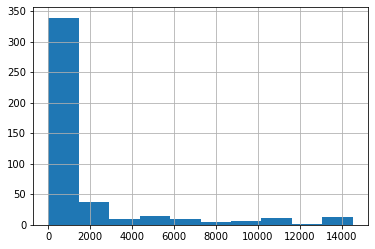

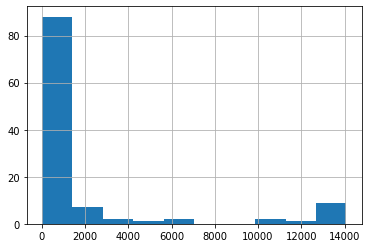

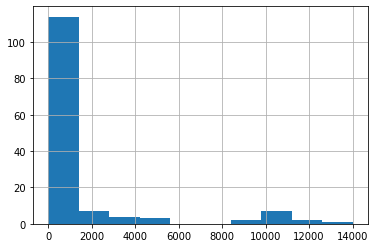

count      140.000000
mean      1621.114286
std       2980.143570
min         12.000000
25%        250.000000
50%        491.000000
75%       1110.750000
max      14006.000000
dtype: float64

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_X_lens = [len(x) for x in X_train_encoded]
pd.Series(train_X_lens).hist()
plt.show()
pd.Series(train_X_lens).describe()

valid_X_lens = [len(x) for x in X_valid_encoded]
pd.Series(valid_X_lens).hist()
plt.show()
pd.Series(valid_X_lens).describe()

test_X_lens = [len(x) for x in X_test_encoded]
pd.Series(test_X_lens).hist()
plt.show()
pd.Series(test_X_lens).describe()

Generate Batches

In [15]:
import random 
import torch
from sklearn.utils import shuffle

def generate_batches(data, labels, seq_len, batch_size, idx_unk):
  data_shu, labels_shu = data, labels
  
  slice_start = 0
  slice_end = batch_size
  num_batches = len(data_shu) // batch_size   #drop the last batch
  
  
  for i in range(num_batches):    

      batch = np.zeros((batch_size, seq_len), dtype="int")
      #get slice of data
      slice_data = data_shu[slice_start:slice_end]
      ret_labels = labels_shu[slice_start:slice_end]
      sequence_lens = []
      for j, slice_d in enumerate(slice_data):
        
        if seq_len >= len(slice_d):     #if text is longer than the sequence length set, padding with the unknown word token

          sequence_lens.append(len(slice_d))  #keep actual seg_lens

          if idx_unk == -1:
            #pad_seq = list(np.full(seq_len - len(slice_d), word2idx["unknown_emb"]))   #pad sequence with unknown token
            pad_seq = list(np.full(seq_len - len(slice_d), word2idx["pad_token"]) )      #or pad with zeros
          else:
            #pad_seq = list(np.full(seq_len - len(slice_d), idx_unk))                   #pad sequence with the index of a word that maps to unknown token
            pad_seq = list(np.full(seq_len - len(slice_d), word2idx["pad_token"] ) )      #or pad with zeros

          new_len = slice_d + pad_seq          #pad sequence at the end of document
          batch[j:] = np.array(new_len)
        
        else:   #sample the text

          sequence_lens.append(seq_len)  #keep actual seg_lens

          rand_start = random.randrange(0, len(slice_data[j]) - seq_len)
          new_len = slice_d[rand_start : rand_start + seq_len]
          batch[j:] = np.array(new_len)

      batch = torch.from_numpy(batch)
      ret_labels = torch.from_numpy(ret_labels)
      sequence_lens = torch.tensor(sequence_lens)
      yield batch, ret_labels, sequence_lens

      slice_start = slice_end
      slice_end = slice_end + batch_size


Define neural network architecture.

In [16]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, embeddings_matrix ):
    super(LSTMModel, self).__init__()

    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.output_size = output_dim
    self.n_layers = num_layers
    #embedding layer
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    #lstm layer
    self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = num_layers, dropout = 0.3, batch_first = True )

    #dropout layer
    self.dropout = nn.Dropout(0.5)

    #dense layer
    self.fc = nn.Linear(hidden_dim, output_dim)

    #sigmoid activation function
    self.sig = nn.Sigmoid()

    self.init_weigths(embeddings_matrix)
  
  def init_weigths(self, embeddings_matrix):
    self.embeddings.weight =  torch.nn.Parameter(embeddings_matrix)


  def forward(self, batch, seq_lens_train, hidden):
    
    assert (list(batch.size()) == [BATCH_SIZE, SEQUENCE_LEN]), "Batch shape not appropriate"

    #embedding layer
    embedded = self.embeddings(batch)
    assert (list(embedded.size()) == [BATCH_SIZE, SEQUENCE_LEN, self.embedding_dim ]), "Embedded batch shape not appropriate"
    
    #pack padded sequences
    packed_batch = torch.nn.utils.rnn.pack_padded_sequence(embedded, seq_lens_train, batch_first=True, enforce_sorted=False)
    #lstm layer
    lstm_out_packed, lstm_hidden_packed = self.lstm(packed_batch, hidden)

    output, input_sizes = torch.nn.utils.rnn.pad_packed_sequence(lstm_out_packed, batch_first=True)
    
  
    #stack up lstm ouput
    #lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

    #dropout
    drop_out = self.dropout(lstm_hidden_packed[0][-1])

    #fully-connected layer
    out = self.fc(drop_out)
    assert (list(out.size()) == [BATCH_SIZE, self.output_size ]), "Fully-connected layer output batch shape not appropriate"

    #sigmoid function
    sig_out = self.sig(out)
    assert (list(sig_out.size()) == [BATCH_SIZE, self.output_size ]), "Sigmoid layer output batch shape not appropriate"

    #reshape to get batch_size first
    #sig_out = sig_out.view(BATCH_SIZE, -1)

    #get last one
    #sig_out = sig_out[:, -1]

    return sig_out, lstm_hidden_packed


  def init_hidden(self):

    weight = next(self.parameters()).data
    gpu = torch.cuda.is_available()

    #initialize hidden_state
    if (gpu):
      hidden = (weight.new(self.n_layers, BATCH_SIZE, self.hidden_dim).zero_().cuda(),
                        weight.new(self.n_layers, BATCH_SIZE, self.hidden_dim).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, BATCH_SIZE, self.hidden_dim).zero_(),
                        weight.new(self.n_layers, BATCH_SIZE, self.hidden_dim).zero_())
    return hidden

Instantiate the network.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Network parameters
VOCAB_SIZE = emb_weight_matrix.shape[0]
EMBEDDING_DIM = emb_weight_matrix.shape[1]
HIDDEN_DIM = 256
OUTPUT_DIM = 1
NUM_LAYERS = 2

emb_weight_matrix = torch.FloatTensor(emb_weight_matrix)
emb_weight_matrix.size()
model = LSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, emb_weight_matrix).to(device)
print(model)


cuda
LSTMModel(
  (embeddings): Embedding(400002, 50)
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


Build training loop

[tensor(0.6902), tensor(0.6896), tensor(0.6890), tensor(0.6897), tensor(0.6888), tensor(0.6880), tensor(0.6890), tensor(0.6880), tensor(0.6883), tensor(0.6879), tensor(0.6876), tensor(0.6881), tensor(0.6872), tensor(0.6872), tensor(0.6879), tensor(0.6879), tensor(0.6876), tensor(0.6865), tensor(0.6856), tensor(0.6874), tensor(0.6846), tensor(0.6853), tensor(0.6844), tensor(0.6824), tensor(0.6758), tensor(0.6681), tensor(0.6902), tensor(0.6778), tensor(0.6285), tensor(0.6049), tensor(0.5998), tensor(0.6362), tensor(0.6127), tensor(0.5970), tensor(0.6299), tensor(0.5697), tensor(0.6150), tensor(0.6345), tensor(0.6177), tensor(0.7298), tensor(0.6399), tensor(0.5570), tensor(0.6333), tensor(0.5558), tensor(0.6307), tensor(0.5435), tensor(0.5447), tensor(0.6332), tensor(0.4883), tensor(0.5481), tensor(0.6106), tensor(0.5290), tensor(0.5201), tensor(0.5241), tensor(0.6024), tensor(0.5636), tensor(0.5200), tensor(0.5313), tensor(0.5840), tensor(0.5138), tensor(0.5369), tensor(0.5443), tensor(

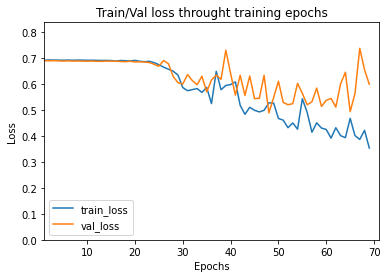

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
learning_rate = 0.0001
EPOCHS = 70    
BATCH_SIZE = 50
SEQUENCE_LEN = 200

gpu = torch.cuda.is_available()
model = LSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, emb_weight_matrix)

if(gpu):
  model.cuda()

# Loss and Optimizer
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

clip = 5

#set model to training mode
model.train()
train_losses = []
val_losses = []


for epoch in range(EPOCHS):
  counter = 0
  
  train_loss = []
  for batch, labels, seq_lens_train in generate_batches(X_train_encoded, Y_train, SEQUENCE_LEN, BATCH_SIZE, idx_unk):
    
    #initialize hidden state
    h = model.init_hidden()
    
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    #Forward + Backward + Optimize

    model.zero_grad()  # zero the gradient buffer
    
    if (gpu):
      batch = batch.cuda()
      seq_lens_train = seq_lens_train.cuda()
      labels =labels.cuda()

    output, h = model(batch, seq_lens_train, h)

    #compute the loss    
    loss = criterion(output.squeeze(), labels.float())

    loss.backward()
    train_loss.append(loss.data)
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  
  train_losses.append(torch.mean(torch.tensor(train_loss)))
  validation_loss = []
  model.eval()

  for batch, labels, seq_lens_val in generate_batches(X_valid_encoded, Y_valid, SEQUENCE_LEN, BATCH_SIZE, idx_unk):

    val_h = model.init_hidden()
    val_h = tuple([each.data for each in val_h])

    if (gpu):
      batch = batch.cuda()
      seq_lens_val = seq_lens_val.cuda()
      labels =labels.cuda()

    output, val_h = model(batch, seq_lens_val, val_h)
    val_loss = criterion(output.squeeze(), labels.float())

    validation_loss.append(val_loss.data)

  val_losses.append(torch.mean(torch.tensor(validation_loss)))
  
  #switch back to train mode
  model.train()

plt.plot(np.array(train_losses), label = 'train_loss')
plt.plot(np.array(val_losses), label = 'val_loss')
plt.ylim([0, max([max(train_losses),max(val_losses)]) + 0.1])
plt.xlim(1, EPOCHS + 1)
plt.title("Train/Val loss throught training epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.save(model.state_dict(), "/content/drive/My Drive/Models/politifact/mymodel_lr00001ep70_dout05dout03lstm.pt")

import smtplib
import ssl

def notify_me(address, content):
    port = 465  # For SSL
    smtp_server = "smtp.gmail.com"
    sender_email = "jup.notify@gmail.com"  # Enter your address
    receiver_email = address  # Enter receiver address
    message = f"""{content}"""

    context = ssl.create_default_context()
    with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
        server.login(sender_email, "jup_1392")
        server.sendmail(sender_email, receiver_email, message)

# Example Usage
notify_me("staviatrop@gmail.com", "Telooos")

Evaluate on Test Set

In [18]:
model = LSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, emb_weight_matrix)
gpu = torch.cuda.is_available()
if (gpu):
  model.cuda()

model.load_state_dict(torch.load("/content/drive/My Drive/Models/politifact/mymodel_lr00001ep70_dout05dout03lstm.pt"))
print(model.parameters())
model.eval()
SEQUENCE_LEN = 200
BATCH_SIZE = 50
criterion = nn.BCELoss().to(device)
print(model)

# model.eval()
# gpu = torch.cuda.is_available()
# if (gpu):
#   model.cuda()


test_losses = []
num_correct = 0


tp = 0
fp = 0
fn = 0
for test_batch, true_labels, seq_lens_test in generate_batches(X_test_encoded, Y_test, SEQUENCE_LEN, BATCH_SIZE, idx_unk):       #random subsampling

  test_h = model.init_hidden()
  test_h = tuple([each.data for each in test_h])

  if (gpu):
    test_batch = test_batch.cuda()
    seq_lens_test = seq_lens_test.cuda()
    true_labels = true_labels.cuda()

  output, test_h = model(test_batch, seq_lens_test, test_h)

  test_loss = criterion(output.squeeze(), true_labels.float())
  test_losses.append(test_loss.data)

  predictions = torch.round(output.squeeze())
  correct_tensor = predictions.eq(true_labels.float().view_as(predictions))

  correct = np.squeeze(correct_tensor.cpu().numpy())
  num_correct += np.sum(correct)

  pred_num = predictions.cpu().detach().numpy()
  true_num = true_labels.cpu().numpy()
  for i, pred in enumerate(pred_num):

    if pred == 1:
      if true_num[i] == 1:
        tp = tp + 1
      else:
        fp = fp + 1
    else:
      if true_num[i] == 1:
        fn = fn + 1

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(torch.mean(torch.tensor(test_losses))))

# accuracy over all test data
test_acc = num_correct/len(X_test)
print("Test accuracy: {:.3f}".format(test_acc))  

# precision over all test data
precision = tp/(tp + fp)
print("Test precision: {:.3f}".format(precision))

# recall over all test data
recall = tp/(tp + fn)
print("Test recall: {:.3f}".format(recall))

# f1_score over all test data
f1_score = 2* (precision * recall)/(precision + recall)
print("Test f1_score: {:.3f}".format(f1_score))

<generator object Module.parameters at 0x7f4850b42570>
LSTMModel(
  (embeddings): Embedding(400002, 50)
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)
Test loss: 0.515
Test accuracy: 0.550
Test precision: 0.800
Test recall: 0.720
Test f1_score: 0.758
